## Load and Visualize the Dataset

Dataset Link: [Kaggle-Butterfly Image Classification dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)

### Load Images

In [1]:
import pandas as pd

# Load train csv file
train_ds = pd.read_csv('./data/butterfly_image_classification/Training_set.csv')
print(train_ds.head(5))
train_ds = train_ds.sample(frac=1, random_state=42)
train_ds.head(5)

      filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART


,filename,label
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART
1703,Image_1704.jpg,MONARCH
5862,Image_5863.jpg,QUESTION MARK
1773,Image_1774.jpg,APPOLLO
5709,Image_5710.jpg,BANDED PEACOCK


In [2]:
m = len(train_ds)
print(f'DS size: {m}')

val_ds = train_ds[6000:]
train_ds = train_ds[:6000]

print(f'Train DS size: {len(train_ds)}, Val DS size: {len(val_ds)}')

DS size: 6499
Train DS size: 6000, Val DS size: 499


In [3]:
# Load actual images
img_dir = './data/butterfly_image_classification/train/'

train_ds['filename'] = train_ds['filename'].map(lambda x: img_dir + x)
img_dir + train_ds.head(1)['filename']

5572    ./data/butterfly_image_classification/train/./...
Name: filename, dtype: object

In [4]:
train_ds.head(5)

,filename,label
5572,./data/butterfly_image_classification/train/Im...,GREEN CELLED CATTLEHEART
1703,./data/butterfly_image_classification/train/Im...,MONARCH
5862,./data/butterfly_image_classification/train/Im...,QUESTION MARK
1773,./data/butterfly_image_classification/train/Im...,APPOLLO
5709,./data/butterfly_image_classification/train/Im...,BANDED PEACOCK


In [5]:
import tensorflow as tf
from PIL import Image
import numpy as np

def load_img(img_path):
    img = Image.open(img_path)
    img = img.resize((128, 128))
    img_arr = np.array(img)
    return img_arr

train_ds['img'] = train_ds['filename'].map(load_img)

2025-04-10 09:43:48.484821: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 09:43:48.485706: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 09:43:48.491579: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-10 09:43:48.505067: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744258428.527728   11882 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744258428.53

In [6]:
train_ds.head(5)

,filename,label,img
5572,./data/butterfly_image_classification/train/Im...,GREEN CELLED CATTLEHEART,"[[[238, 238, 240], [239, 239, 241], [239, 238,..."
1703,./data/butterfly_image_classification/train/Im...,MONARCH,"[[[115, 135, 72], [111, 131, 71], [110, 131, 6..."
5862,./data/butterfly_image_classification/train/Im...,QUESTION MARK,"[[[78, 104, 11], [66, 91, 8], [54, 81, 6], [44..."
1773,./data/butterfly_image_classification/train/Im...,APPOLLO,"[[[82, 50, 3], [82, 50, 3], [85, 51, 3], [85, ..."
5709,./data/butterfly_image_classification/train/Im...,BANDED PEACOCK,"[[[145, 174, 34], [147, 176, 36], [150, 179, 3..."


### Visualize images

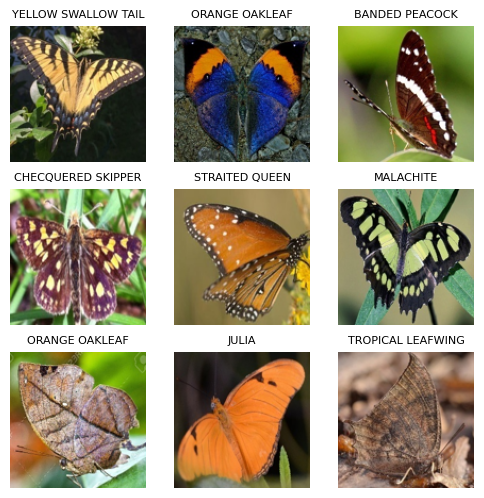

In [7]:
import matplotlib.pyplot as plt
import random

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(0, 9):
    img_ind = random.randint(0, len(train_ds))
    data_pt = train_ds.iloc[img_ind]
    ax[i//3][i%3].imshow(data_pt['img'])
    ax[i//3][i%3].set_title(data_pt['label'], fontsize=8)
    ax[i//3][i%3].axis('off')